# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False#True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 10


Let us show some of the training images, for fun.



plane  bird   dog  deer


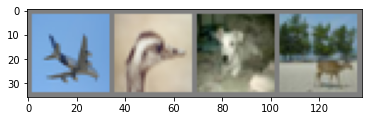

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

def compute_conv_dim(dim_size):
    return (dim_size - 5 + 2 * 2) + 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #let's start with a convolutional layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 2)
        #and then add a pooling layer
        self.maxPool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #in order to obtain better results, let's try to add another convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2)
        #and finally add three fully connected layers to reduce gradually
        #the dimension of the output and linearize it
        self.linear1 = nn.Linear(in_features = 64 * 8 * 8, out_features = 1024)
        self.linear2 = nn.Linear(in_features = 1024, out_features = 256)
        self.linear3 = nn.Linear(in_features = 256, out_features = 64)
        self.linear4 = nn.Linear(in_features = 64, out_features = 10)

    def forward(self, x):
        #exploiting GPU
        x = x.cuda()
        #convolutional layer, relu and maxPool
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxPool(x)
        #second convolutional layer, relu and maxPool
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxPool(x)
        #linearization and fully connected layers to reduce the output
        x = x.view(-1, 64*8*8)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        x = self.linear4(x)
        return x
    

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [ ]:
num_epoch = 10  # Your code here!

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.cpu().item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.291
[1,  2000] loss: 2.077
[1,  3000] loss: 1.886
[1,  4000] loss: 1.730
[1,  5000] loss: 1.633
[1,  6000] loss: 1.569
[1,  7000] loss: 1.506
[1,  8000] loss: 1.432
[1,  9000] loss: 1.385
[1, 10000] loss: 1.368
[1, 11000] loss: 1.328
[1, 12000] loss: 1.291
[2,  1000] loss: 1.202
[2,  2000] loss: 1.153
[2,  3000] loss: 1.179
[2,  4000] loss: 1.120
[2,  5000] loss: 1.128
[2,  6000] loss: 1.091
[2,  7000] loss: 1.080
[2,  8000] loss: 1.044
[2,  9000] loss: 1.030
[2, 10000] loss: 1.023
[2, 11000] loss: 0.967
[2, 12000] loss: 0.998
[3,  1000] loss: 0.826
[3,  2000] loss: 0.840
[3,  3000] loss: 0.825
[3,  4000] loss: 0.846
[3,  5000] loss: 0.832
[3,  6000] loss: 0.848
[3,  7000] loss: 0.817
[3,  8000] loss: 0.812
[3,  9000] loss: 0.836
[3, 10000] loss: 0.837
[3, 11000] loss: 0.805
[3, 12000] loss: 0.789
[4,  1000] loss: 0.612
[4,  2000] loss: 0.638
[4,  3000] loss: 0.618
[4,  4000] loss: 0.617
[4,  5000] loss: 0.615
[4,  6000] loss: 0.653
[4,  7000] loss: 0.640
[4,  8000] 

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

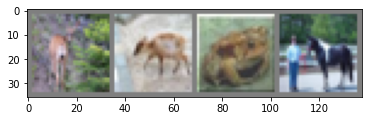

GroundTruth:    deer  deer  frog horse
Predicted:      deer  deer  deer horse


In [ ]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.cpu().data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 10000 test images: 72.32 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [ ]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.cpu().data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81.70 %
Accuracy of car   : 75.00 %
Accuracy of bird  : 60.10 %
Accuracy of cat   : 53.10 %
Accuracy of deer  : 71.50 %
Accuracy of dog   : 56.90 %
Accuracy of frog  : 80.40 %
Accuracy of horse : 77.40 %
Accuracy of ship  : 82.90 %
Accuracy of truck : 84.20 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

1. I used 10 classes and I reached an accuracy of 72.32%!
2. I started with a simple network with only one convolutional layer and one linearization layer. With this configuration a reached really pour results. Then, after some trials, it came out that adding one other convolutional layer, performing the max pooling, adding some fully connected linearization layers and increasing the number of epochs improved the results till about 70%. 
Finally, I increased the dimensions of the network exploiting the advantage of time provided by the GPU and I reached the final result.
To tell the truth, I tried also to make the network design reacher, adding layers, but the results were that or the performances didn't increase significantly or the training time was incredibly long. Overall, I expected these results because at the beginning it is easy to improve the performances with at trial-and-error technic but then it becomes more and more difficult to improve them.
3. There are some tricks about implementation that will be usefull in the future. Then, it was usefull thinking about the dimensions in each layer. Finally, another key lesson was the importance of the pooling layers.

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**





### Exercise chapter 6
What classification accuracy do you get if you omit the fully-connected layer, and just use the convolutional-pooling layer and softmax layer? Does the inclusion of the fully-connected layer help?

#### Answer
In order to work with this program, I had to change some lines of code, as the program was written for Python 2. Then, it doesn't use pytorch but it is not a problem for the purposes of the exercise, that wants ot examinate the importance of the layers and not the specific implementations.

In the first tab are reported the functions to declare the layers and to train/validate the network.

In the second tab, it is trained and validated a network **without** the fully connected layer whereas in the third, a network **with** the fully-connected layer is trained.

**Without**: the model reaches the best accuracy at iteration 13500 over 30000 with a validation accuracy of 98.70% and a test accuracy of 98.62%.

**With**: the model reaches the best accuracy at iteration 30000 over 30000 with a validation accuracy of 98.66% and a test accuracy of 98.80%.

As it can be seen below, the network **without** the fully-connected layer, performs worse than that **with** the layer, even if the difference is not so big. The network with the layer takes more to train. The difference is that the network with the fully-connected layer is continuing to improve also at the end, and in fact it reaches the best performance at the last iteration. For this reason, this network could have better performnces if left to train for more epochs.

So, at the end, I would say that the fully-connected layer helps lso if further experiments should be done.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [34]:
"""network3.py
~~~~~~~~~~~~~~

A Theano-based program for training and running simple neural
networks.

Supports several layer types (fully connected, convolutional, max
pooling, softmax), and activation functions (sigmoid, tanh, and
rectified linear units, with more easily added).

When run on a CPU, this program is much faster than network.py and
network2.py.  However, unlike network.py and network2.py it can also
be run on a GPU, which makes it faster still.

Because the code is based on Theano, the code is different in many
ways from network.py and network2.py.  However, where possible I have
tried to maintain consistency with the earlier programs.  In
particular, the API is similar to network2.py.  Note that I have
focused on making the code simple, easily readable, and easily
modifiable.  It is not optimized, and omits many desirable features.

This program incorporates ideas from the Theano documentation on
convolutional neural nets (notably,
http://deeplearning.net/tutorial/lenet.html ), from Misha Denil's
implementation of dropout (https://github.com/mdenil/dropout ), and
from Chris Olah (http://colah.github.io ).

Written for Theano 0.6 and 0.7, needs some changes for more recent
versions of Theano.

"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.nnet import conv
from theano.tensor.nnet import softmax
from theano.tensor import shared_randomstreams
from theano.tensor.signal.pool import pool_2d

# Activation functions for neurons
def linear(z): return z
def ReLU(z): return T.maximum(0.0, z)
from theano.tensor.nnet import sigmoid
from theano.tensor import tanh


#### Constants
GPU = True
if GPU:
    print ("Trying to run under a GPU.  If this is not desired, then modify "+\
        "network3.py\nto set the GPU flag to False.")
    try: theano.config.device = 'gpu'
    except: pass # it's already set
    theano.config.floatX = 'float32'
else:
    print ("Running with a CPU.  If this is not desired, then the modify "+\
        "network3.py to set\nthe GPU flag to True.")

#### Load the MNIST data
def load_data_shared(filename="/content/drive/My Drive/Colab Notebooks/mnist.pkl.gz"):
    f = gzip.open(filename, 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='iso-8859-1')
    f.close()
    def shared(data):
        """Place the data into shared variables.  This allows Theano to copy
        the data to the GPU, if one is available.

        """
        shared_x = theano.shared(
            np.asarray(data[0], dtype=theano.config.floatX), borrow=True)
        shared_y = theano.shared(
            np.asarray(data[1], dtype=theano.config.floatX), borrow=True)
        return shared_x, T.cast(shared_y, "int32")
    return [shared(training_data), shared(validation_data), shared(test_data)]

#### Main class used to construct and train networks
class Network(object):

    def __init__(self, layers, mini_batch_size):
        """Takes a list of `layers`, describing the network architecture, and
        a value for the `mini_batch_size` to be used during training
        by stochastic gradient descent.

        """
        self.layers = layers
        self.mini_batch_size = mini_batch_size
        self.params = [param for layer in self.layers for param in layer.params]
        self.x = T.matrix("x")
        self.y = T.ivector("y")
        init_layer = self.layers[0]
        init_layer.set_inpt(self.x, self.x, self.mini_batch_size)
        for j in range(1, len(self.layers)):
            prev_layer, layer  = self.layers[j-1], self.layers[j]
            layer.set_inpt(
                prev_layer.output, prev_layer.output_dropout, self.mini_batch_size)
        self.output = self.layers[-1].output
        self.output_dropout = self.layers[-1].output_dropout

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            validation_data, test_data, lmbda=0.0):
        """Train the network using mini-batch stochastic gradient descent."""
        training_x, training_y = training_data
        validation_x, validation_y = validation_data
        test_x, test_y = test_data

        # compute number of minibatches for training, validation and testing
        num_training_batches = size(training_data)//mini_batch_size
        num_validation_batches = size(validation_data)//mini_batch_size
        num_test_batches = size(test_data)//mini_batch_size

        # define the (regularized) cost function, symbolic gradients, and updates
        l2_norm_squared = sum([(layer.w**2).sum() for layer in self.layers])
        cost = self.layers[-1].cost(self)+\
               0.5*lmbda*l2_norm_squared/num_training_batches
        grads = T.grad(cost, self.params)
        updates = [(param, param-eta*grad)
                   for param, grad in zip(self.params, grads)]

        # define functions to train a mini-batch, and to compute the
        # accuracy in validation and test mini-batches.
        i = T.lscalar() # mini-batch index
        train_mb = theano.function(
            [i], cost, updates=updates,
            givens={
                self.x:
                training_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                training_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        validate_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                validation_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                validation_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        test_mb_accuracy = theano.function(
            [i], self.layers[-1].accuracy(self.y),
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size],
                self.y:
                test_y[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        self.test_mb_predictions = theano.function(
            [i], self.layers[-1].y_out,
            givens={
                self.x:
                test_x[i*self.mini_batch_size: (i+1)*self.mini_batch_size]
            })
        # Do the actual training
        best_validation_accuracy = 0.0
        for epoch in range(epochs):
            for minibatch_index in range(num_training_batches):
                iteration = num_training_batches*epoch+minibatch_index
                if iteration % 1000 == 0:
                    print("Training mini-batch number {0}".format(iteration))
                cost_ij = train_mb(minibatch_index)
                if (iteration+1) % num_training_batches == 0:
                    validation_accuracy = np.mean(
                        [validate_mb_accuracy(j) for j in range(num_validation_batches)])
                    print("Epoch {0}: validation accuracy {1:.2%}".format(
                        epoch, validation_accuracy))
                    if validation_accuracy >= best_validation_accuracy:
                        print("This is the best validation accuracy to date.")
                        best_validation_accuracy = validation_accuracy
                        best_iteration = iteration
                        if test_data:
                            test_accuracy = np.mean(
                                [test_mb_accuracy(j) for j in range(num_test_batches)])
                            print('The corresponding test accuracy is {0:.2%}'.format(
                                test_accuracy))
        print("Finished training network.")
        print("Best validation accuracy of {0:.2%} obtained at iteration {1}".format(
            best_validation_accuracy, best_iteration))
        print("Corresponding test accuracy of {0:.2%}".format(test_accuracy))

#### Define layer types

class ConvPoolLayer(object):
    """Used to create a combination of a convolutional and a max-pooling
    layer.  A more sophisticated implementation would separate the
    two, but for our purposes we'll always use them together, and it
    simplifies the code, so it makes sense to combine them.

    """

    def __init__(self, filter_shape, image_shape, poolsize=(2, 2),
                 activation_fn=sigmoid):
        """`filter_shape` is a tuple of length 4, whose entries are the number
        of filters, the number of input feature maps, the filter height, and the
        filter width.

        `image_shape` is a tuple of length 4, whose entries are the
        mini-batch size, the number of input feature maps, the image
        height, and the image width.

        `poolsize` is a tuple of length 2, whose entries are the y and
        x pooling sizes.

        """
        self.filter_shape = filter_shape
        self.image_shape = image_shape
        self.poolsize = poolsize
        self.activation_fn=activation_fn
        # initialize weights and biases
        n_out = (filter_shape[0]*np.prod(filter_shape[2:])/np.prod(poolsize))
        self.w = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=np.sqrt(1.0/n_out), size=filter_shape),
                dtype=theano.config.floatX),
            borrow=True)
        self.b = theano.shared(
            np.asarray(
                np.random.normal(loc=0, scale=1.0, size=(filter_shape[0],)),
                dtype=theano.config.floatX),
            borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape(self.image_shape)
        conv_out = conv.conv2d(
            input=self.inpt, filters=self.w, filter_shape=self.filter_shape,
            image_shape=self.image_shape)
        pooled_out = pool_2d(
            input=conv_out, ds=self.poolsize, ignore_border=True, mode = 'max')
        self.output = self.activation_fn(
            pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.output_dropout = self.output # no dropout in the convolutional layers

class FullyConnectedLayer(object):

    def __init__(self, n_in, n_out, activation_fn=sigmoid, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.activation_fn = activation_fn
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.asarray(
                np.random.normal(
                    loc=0.0, scale=np.sqrt(1.0/n_out), size=(n_in, n_out)),
                dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.asarray(np.random.normal(loc=0.0, scale=1.0, size=(n_out,)),
                       dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = self.activation_fn(
            (1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = self.activation_fn(
            T.dot(self.inpt_dropout, self.w) + self.b)

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))

class SoftmaxLayer(object):

    def __init__(self, n_in, n_out, p_dropout=0.0):
        self.n_in = n_in
        self.n_out = n_out
        self.p_dropout = p_dropout
        # Initialize weights and biases
        self.w = theano.shared(
            np.zeros((n_in, n_out), dtype=theano.config.floatX),
            name='w', borrow=True)
        self.b = theano.shared(
            np.zeros((n_out,), dtype=theano.config.floatX),
            name='b', borrow=True)
        self.params = [self.w, self.b]

    def set_inpt(self, inpt, inpt_dropout, mini_batch_size):
        self.inpt = inpt.reshape((mini_batch_size, self.n_in))
        self.output = softmax((1-self.p_dropout)*T.dot(self.inpt, self.w) + self.b)
        self.y_out = T.argmax(self.output, axis=1)
        self.inpt_dropout = dropout_layer(
            inpt_dropout.reshape((mini_batch_size, self.n_in)), self.p_dropout)
        self.output_dropout = softmax(T.dot(self.inpt_dropout, self.w) + self.b)

    def cost(self, net):
        "Return the log-likelihood cost."
        return -T.mean(T.log(self.output_dropout)[T.arange(net.y.shape[0]), net.y])

    def accuracy(self, y):
        "Return the accuracy for the mini-batch."
        return T.mean(T.eq(y, self.y_out))


#### Miscellanea
def size(data):
    "Return the size of the dataset `data`."
    return data[0].get_value(borrow=True).shape[0]

def dropout_layer(layer, p_dropout):
    srng = shared_randomstreams.RandomStreams(
        np.random.RandomState(0).randint(999999))
    mask = srng.binomial(n=1, p=1-p_dropout, size=layer.shape)
    return layer*T.cast(mask, theano.config.floatX)

Trying to run under a GPU.  If this is not desired, then modify network3.py
to set the GPU flag to False.


In [36]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

training_data, validation_data, test_data = load_data_shared("/content/drive/My Drive/Colab Notebooks/mnist.pkl.gz")
mini_batch_size = 10
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2)),
        #FullyConnectedLayer(n_in=20*12*12, n_out=100),
        #SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)
        SoftmaxLayer(n_in=20*12*12, n_out=10)], mini_batch_size)
net.SGD(training_data, 60, mini_batch_size, 0.1, 
            validation_data, test_data)   

/usr/local/lib/python3.6/dist-packages/theano/tensor/nnet/conv.py:98: UserWarning: theano.tensor.nnet.conv.conv2d is deprecated. Use theano.tensor.nnet.conv2d instead.
  warnings.warn("theano.tensor.nnet.conv.conv2d is deprecated."
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.


Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 92.88%
This is the best validation accuracy to date.
The corresponding test accuracy is 92.05%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.46%
This is the best validation accuracy to date.
The corresponding test accuracy is 95.99%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 97.34%
This is the best validation accuracy to date.
The corresponding test accuracy is 97.00%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-

In [37]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

training_data, validation_data, test_data = load_data_shared("/content/drive/My Drive/Colab Notebooks/mnist.pkl.gz")
mini_batch_size = 10
net = Network([
        ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
                      filter_shape=(20, 1, 5, 5), 
                      poolsize=(2, 2)),
        FullyConnectedLayer(n_in=20*12*12, n_out=100),
        SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)
        #SoftmaxLayer(n_in=20*12*12, n_out=10)], mini_batch_size)
net.SGD(training_data, 60, mini_batch_size, 0.1, 
            validation_data, test_data)   

/usr/local/lib/python3.6/dist-packages/theano/tensor/nnet/conv.py:98: UserWarning: theano.tensor.nnet.conv.conv2d is deprecated. Use theano.tensor.nnet.conv2d instead.
  warnings.warn("theano.tensor.nnet.conv.conv2d is deprecated."
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:231: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.


Training mini-batch number 0
Training mini-batch number 1000
Training mini-batch number 2000
Training mini-batch number 3000
Training mini-batch number 4000
Epoch 0: validation accuracy 93.89%
This is the best validation accuracy to date.
The corresponding test accuracy is 93.20%
Training mini-batch number 5000
Training mini-batch number 6000
Training mini-batch number 7000
Training mini-batch number 8000
Training mini-batch number 9000
Epoch 1: validation accuracy 96.10%
This is the best validation accuracy to date.
The corresponding test accuracy is 95.74%
Training mini-batch number 10000
Training mini-batch number 11000
Training mini-batch number 12000
Training mini-batch number 13000
Training mini-batch number 14000
Epoch 2: validation accuracy 96.99%
This is the best validation accuracy to date.
The corresponding test accuracy is 96.84%
Training mini-batch number 15000
Training mini-batch number 16000
Training mini-batch number 17000
Training mini-batch number 18000
Training mini-